In [2]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.visualization import array_to_latex

from qiskit_aer import AerSimulator
from qiskit import transpile

import numpy as np
import matplotlib.pyplot as plt


The purpose of this notebook is to implement error correction using a Hamming CSS code of type $[[15, 7, 3]]$ with self-dual matrix given below. The idea is to take a 15 qubit circuit, encode these 15 qubits into the logical zero according to the CSS code, apply a Pauli error channel of probability $p$ to each qubit and then to apply the error-correction algorithm. The single qubit perfect corrects any $X, Y$ or $Z$ error.

The generator matrix we use for this error correction code is given by 
$$H = \begin{bmatrix} 1 & 0 & 1 & 0 & 1 & 0 & 1 & 0 & 1 & 0 & 1 & 0 & 1 & 0 & 1 \\
0 & 1 & 1 & 0 & 0 & 1 & 1 & 0 & 0 & 1 & 1 & 0 & 0 & 1 & 1 \\
0 & 0 & 0 & 1 & 1 & 1 & 1 & 0 & 0 & 0 & 0 & 1 & 1 & 1 & 1 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1
\end{bmatrix}.$$
It is worth observing that in this form, the entries for the $i^\text{th}$ column are precisely the bitstring representation for the number $i+1$. 

In the process of preparing the logical all-zero state for this error code, we also need to run Gaussian elimination on this matrix. We can do so by swapping the 3rd and 4th row of $H$ and then the 3rd and 8th column of $H$, which yields: 

$$H_{\mathrm{std}} = \begin{bmatrix} 
1 & 0 & 0 & 0 & 1 & 0 & 1 & 1 & 1 & 0 & 1 & 0 & 1 & 0 & 1 \\
0 & 1 & 0 & 0 & 0 & 1 & 1 & 1 & 0 & 1 & 1 & 0 & 0 & 1 & 1 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 1 & 1 & 1 & 1 & 1 & 1 & 1 \\
0 & 0 & 0 & 1 & 1 & 1 & 1 & 0 & 0 & 0 & 0 & 1 & 1 & 1 & 1 \\
\end{bmatrix}.$$

In [3]:
# self-dual [[15, 7, 3]] Hamming code matrix representing H_X and H_Z

H_matrix = [[1,0,1,0,1,0,1,0,1,0,1,0,1,0,1],[0,1,1,0,0,1,1,0,0,1,1,0,0,1,1],[0,0,0,1,1,1,1,0,0,0,0,1,1,1,1],[0,0,0,0,0,0,0,1,1,1,1,1,1,1,1]]

# the matrix for generators consisting of X gates, after Gaussian elimination
# swaps the 3rd and 4th generators above and swaps the 3rd and 8th qubits

H_std = [[1,0,0,0,1,0,1,1,1,0,1,0,1,0,1],[0,1,0,0,0,1,1,1,0,1,1,0,0,1,1],[0,0,1,0,0,0,0,0,1,1,1,1,1,1,1],[0,0,0,1,1,1,1,0,0,0,0,1,1,1,1]]

We also include below the components of the logical all-zero state, which is constructed by the projection of the physical all-zero state to the intersection of the eigenspaces for eigenvalue 1 for each generator of the stabilizer group $S$. Equivalently, $|00\cdots 0_L\rangle = \prod_{g \in S} g|00\cdots0\rangle$. 

In [4]:
logical_zero_components = ['110000110011110',
 '011010011001011',
 '000000000000000',
 '101001010101101',
 '101010101010101',
 '010101011010101',
 '001100111100110',
 '100110010110011',
 '111111110000000',
 '111100001111000',
 '100101101001011',
 '110011001100110',
 '000011111111000',
 '010110100101101',
 '001111000011110',
 '011001100110011']

Part of this requires us to apply a Pauli error channel on each of our encoding qubits (after they have been encoded into the logical all-zero state). We provide two ways of circuits which do this in some sense. The first, following one, is more truly random: we use ancilla qubits to create the state $\sqrt{p}|00\rangle + \sqrt{p}|01\rangle + \sqrt{p}|01\rangle + \sqrt{1-3p}|11\rangle$ and then measure this state; based on the outcome, we apply an $X, Y, Z$ or identity gate. 

In [5]:
# creates a Pauli error on a single qubit (with probability p for each of X, Y, or Z errors)
# uses 2 clean ancillas to create the state sqrt(p)|00> + sqrt(p)|01> + sqrt(p)|01> + sqrt(1-3p)|11> 
# then measures and uses the result to implement the pauli error

# input: 
# p : real number in [0,1/3] representing error probability

def pauli_error(p):
    error_register = QuantumRegister(1)
    ancilla_register = AncillaRegister(2)
    classical_register = ClassicalRegister(2)
    qc = QuantumCircuit(error_register, ancilla_register, classical_register)

    theta_0 = 2*np.arccos(np.sqrt(2*p))
    theta_10 = 2*np.arccos(1/np.sqrt(2))
    theta_11 = 2*np.arccos(np.sqrt(p/(1-2*p)))

    # prepares the quantum state sqrt(p)|00> + sqrt(p)|01> + sqrt(p)|01> + \sqrt(1-3p)|11> 
    # on the ancilla register
    qc.ry(theta_0, ancilla_register[1])

    qc.x(ancilla_register[1])
    qc.cry(theta_10, ancilla_register[1], ancilla_register[0])
    qc.x(ancilla_register[1])

    qc.cry(theta_11, ancilla_register[1], ancilla_register[0])

    # measure the probabilities and use the result of the measurement to do X, Y or Z 
    qc.measure(ancilla_register,classical_register)

    with qc.if_test((classical_register,0)):
        qc.x(error_register[0])
    with qc.if_test((classical_register,1)):
        qc.y(error_register[0])
        qc.x(ancilla_register[0])
    with qc.if_test((classical_register,2)):
        qc.z(error_register[0])
        qc.x(ancilla_register[1])
    with qc.if_test((classical_register,3)):
        qc.x(ancilla_register[:])
    return qc

The second is fundamentally much simpler, and just uses numpy to generate a random number to determine which gate appears. The downside is this only really generates a new random number when we construct the circuit, rather than each time we run the circuit. In particular, if one compiles this circuit and runs it for a thousand rounds, the outcome will be the same each time since we are just running the same circuit repeatedly and the randomness was only in the construction.

In [6]:
def pauli_error_numpy(p):
    qc = QuantumCircuit(1)
    randnum = np.random.rand()
    if randnum < p:
        qc.x(0)
    if randnum < 2*p:
        qc.y(0)
    if randnum < 3*p:
        qc.z(0)
    return qc 

The following circuit is the main body of the code. 
Of its pieces, the first of interest is the construction of the all-zero logical qubit. We follow Gottesmann's algorithm, which appeared first in his [thesis](https://arxiv.org/pdf/quant-ph/9705052) (with some errata, though this ends up being irrelevant for our purposes). Since we are working with a CSS code, the algorithm simplifies considerably: we may ignore stabilizers acting only by Z gates, since these act trivially on the physical all-zero state. 

The second piece of interest is the application of the Pauli error channels on each qubit. 

Then, according to the H-matrices in the CSS error code we compute and measure the syndromes. 

Finally, based on the syndromes we correct the errors; since the $H_X$ and $H_Z$ matrices are the same as the code is a self-dual CSS code, we correct the $X$ and $Z$ errors in exactly the same way based on the $X$-syndromes and $Z$-syndromes respectively. 1-qubit $Y$ errors are corrected as up to a global phase they amount to an $X$-error following by a $Z$-error on the same qubit. 

In [7]:
# p : real number in [0,1/3] representing error probability

def CSS_correction(p):

    encoding_qubits = QuantumRegister(size = 15, name = "CSS")

    pauli_error_ancilla = AncillaRegister(size = 2, name = 'pauli-err')
    pauli_error_measurements = ClassicalRegister(size = 2, name = 'pauli-cl')

    x_ancillas = AncillaRegister(size = 4, name = "x ancillas")
    x_syndromes = ClassicalRegister(size = 4, name = "x syndromes")

    z_ancillas = AncillaRegister(size = 4, name = "z ancillas")
    z_syndromes = ClassicalRegister(size = 4, name = "z syndromes")

    output_measurements = ClassicalRegister(size = 15, name = "measurements")

    CSS_circuit = QuantumCircuit(encoding_qubits, x_ancillas, z_ancillas, x_syndromes, z_syndromes, 
                                output_measurements, pauli_error_ancilla, pauli_error_measurements,name="CSS circuit")

    # produce the all-zero logical qubit, using Gottesmann's algorithm
    # because the Gaussian elimination involved swapping
    # column 3 and column 8, we must swap qubits 3 and 8 at the end
    # (really swapping indices 2 and 7 in the register)

    
    for i in range(4):
        CSS_circuit.h(encoding_qubits[i])
        for j in range(4,15):
            if (H_std[i])[j] == 1:
                CSS_circuit.cx(encoding_qubits[i],encoding_qubits[j])

    CSS_circuit.swap(encoding_qubits[2], encoding_qubits[7])

    # add in Pauli errors on each encoding qubit
    # using the pauli_error_ancilla qubits and 
    # pauli_error_measurements clbits
    for i in range(15):
        CSS_circuit.compose(pauli_error(p),inplace=True, qubits = [encoding_qubits[i]] + pauli_error_ancilla[:], clbits = pauli_error_measurements[:])
    

    # produces and measures the X-syndromes
    for syndrome_index, entry in enumerate(H_matrix):
        for index, element in enumerate(entry):
            if element:
                CSS_circuit.cx(encoding_qubits[index], x_ancillas[syndrome_index])

    CSS_circuit.measure(x_ancillas, x_syndromes)
    
    # produces and measures the Z-syndromes
    CSS_circuit.h(z_ancillas[:])

    for syndrome_index, entry in enumerate(H_matrix):
        for index, element in enumerate(entry):
            if element:
                CSS_circuit.cx(z_ancillas[syndrome_index], encoding_qubits[index])
    CSS_circuit.h(z_ancillas[:])

    CSS_circuit.measure(z_ancillas, z_syndromes)

    # corrects X-errors by examination of X-syndromes
    for i in range(15):
        with CSS_circuit.if_test((x_syndromes,i+1)):
            CSS_circuit.x(encoding_qubits[i])
    
    # corrects Z-errors by examination of Z-syndromes
    for i in range(15):
        with CSS_circuit.if_test((z_syndromes,i+1)):
            CSS_circuit.z(encoding_qubits[i])

    # measures the output
    CSS_circuit.measure(encoding_qubits, output_measurements)

    return CSS_circuit
    

We provide below another version using the numpy implementation of the error channel. 

In [8]:
# p : real number in [0,1/3] representing error probability

def CSS_correction_numpy(p):

    encoding_qubits = QuantumRegister(size = 15, name = "CSS")

    x_ancillas = AncillaRegister(size = 4, name = "x ancillas")
    x_syndromes = ClassicalRegister(size = 4, name = "x syndromes")

    z_ancillas = AncillaRegister(size = 4, name = "z ancillas")
    z_syndromes = ClassicalRegister(size = 4, name = "z syndromes")

    output_measurements = ClassicalRegister(size = 15, name = "measurements")

    CSS_circuit = QuantumCircuit(encoding_qubits, x_ancillas, z_ancillas, x_syndromes, z_syndromes, 
                                output_measurements, name="CSS circuit using numpy")

    # produce the all-zero logical qubit, using Gottesmann's algorithm
    # because the Gaussian elimination involved swapping
    # column 3 and column 8, we must swap qubits 3 and 8 at the end
    # (really swapping indices 2 and 7 in the register)

    
    for i in range(4):
        CSS_circuit.h(encoding_qubits[i])
        for j in range(4,15):
            if (H_std[i])[j] == 1:
                CSS_circuit.cx(encoding_qubits[i],encoding_qubits[j])

    CSS_circuit.swap(encoding_qubits[2], encoding_qubits[7])

    # add in Pauli errors on each encoding qubit using numpy
    for i in range(15):
        CSS_circuit.compose(pauli_error_numpy(p),inplace=True, qubits = [encoding_qubits[i]])
    

    # produces and measures the X-syndromes
    for syndrome_index, entry in enumerate(H_matrix):
        for index, element in enumerate(entry):
            if element:
                CSS_circuit.cx(encoding_qubits[index], x_ancillas[syndrome_index])

    CSS_circuit.measure(x_ancillas, x_syndromes)
    
    # produces and measures the Z-syndromes
    CSS_circuit.h(z_ancillas[:])

    for syndrome_index, entry in enumerate(H_matrix):
        for index, element in enumerate(entry):
            if element:
                CSS_circuit.cx(z_ancillas[syndrome_index], encoding_qubits[index])
    CSS_circuit.h(z_ancillas[:])

    CSS_circuit.measure(z_ancillas, z_syndromes)

    # corrects X-errors by examination of X-syndromes
    for i in range(15):
        with CSS_circuit.if_test((x_syndromes,i+1)):
            CSS_circuit.x(encoding_qubits[i])
    
    # corrects Z-errors by examination of Z-syndromes
    for i in range(15):
        with CSS_circuit.if_test((z_syndromes,i+1)):
            CSS_circuit.z(encoding_qubits[i])

    # measures the output
    CSS_circuit.measure(encoding_qubits, output_measurements)

    return CSS_circuit
    

The most interesting part of the computation is to test how often we are able to properly correct our errors as the probability $p$ varies. We should expect that when $p$ is low, as there will only be 0 or 1 qubit errors, we should be able to properly correct for the errors. But as $p$ increases past the probability where we expect to get 2 or more qubit errors, we are less likely to be successful. 

The expected number of errors is given by $p\cdot15$, so when $p$ is below $1/15 \approx 0.067$, we should expect to succesfully correct more likely than not, and as $p$ increases above 1/15 we should expect to start failing at error correction much more frequently.

We will run the above circuits using Qiskit Aer and include the "success rate", which is the percentage of rounds where the measured output after correction is one of the component vectors of the logical all-zero state. When $p$ is low, this should be close to 1, and when $p$ is high, this should be close to 0. Note that running the non-numpy version for $n$ rounds is significantly slower than running the numpy version for 1 round $n$ times, but for completeness, we illustrate that both work. 

First, we will test using the non-numpy implementation the extreme cases, where $p = 0$ and $p \approx 1/3$, for 10 rounds each.

In [61]:
p = 0.00

simulator = AerSimulator()

rounds = 10

compiled_circuit = transpile(CSS_correction(p), simulator)

job = simulator.run(compiled_circuit, shots = rounds)

counts = job.result().get_counts()

success = 0.0

for key in counts:
    if key[3:18] in logical_zero_components:
        success += counts[key]

print(success/rounds)


1.0


In [62]:
p = 0.3333

simulator = AerSimulator()

rounds = 10

compiled_circuit = transpile(CSS_correction(p), simulator)

job = simulator.run(compiled_circuit, shots = rounds)

counts = job.result().get_counts()

success = 0.0

for key in counts:
    if key[3:18] in logical_zero_components:
        success += counts[key]

print(success/rounds)

0.1


Next, we use the numpy implementation 100 times (for 1 round each in the Aer simulator) for values of $p$ which are closer to the boundary, $p = 0.04$ and $p = 0.08$. 

In [63]:
p = 0.04

simulator = AerSimulator()

success = 0.0
totalrounds = 100

for i in range(totalrounds):
    rounds = 1
    compiled_circuit = transpile(CSS_correction_numpy(p), simulator)
    job = simulator.run(compiled_circuit, shots = rounds)
    counts = job.result().get_counts()
    for key in counts:
        if key[:15] in logical_zero_components:
            success += counts[key]

print(success/totalrounds)

0.91


In [64]:
p = 0.08

simulator = AerSimulator()

success = 0.0
totalrounds = 100

for i in range(totalrounds):
    
    rounds = 1
    compiled_circuit = transpile(CSS_correction_numpy(p), simulator)
    job = simulator.run(compiled_circuit, shots = rounds)
    counts = job.result().get_counts()
    for key in counts:
        if key[:15] in logical_zero_components:
            success += counts[key]

print(success/totalrounds)

0.64


For fun, it is interesting to verify that our Pauli errors are genuinely introducing Pauli errors. We do so below, by running pauli_error(.2) for 1000 rounds and measuring the output. We should expect an output of 1 (corresponding to an X or Y error) roughly $2p \cdot 1000 = 400$ times, with 200 coming from each possibility, and an output of 0 (corresponding to an identity or Z error) roughly $(1 - 3\cdot p + p)\cdot 1000 = 600$ times, with 400 coming from the identity matrix case and 200 from the Z error case. 

In [5]:
qr = QuantumRegister(1)
ar = AncillaRegister(2)
cr = ClassicalRegister(2)
output = ClassicalRegister(1)

qc = QuantumCircuit(qr, ar, cr, output)

qc.compose(pauli_error(0.2), inplace=True, qubits = qr[:] + ar[:], clbits = cr[:])

qc.measure(qr, output)

simulator = AerSimulator()
rounds = 1000
compiled_circuit = transpile(qc, simulator)
job = simulator.run(compiled_circuit, shots = rounds)
counts = job.result().get_counts()

counts

{'1 00': 203, '0 10': 197, '0 11': 408, '1 01': 192}

Text(0, 0.5, 'Success probability')

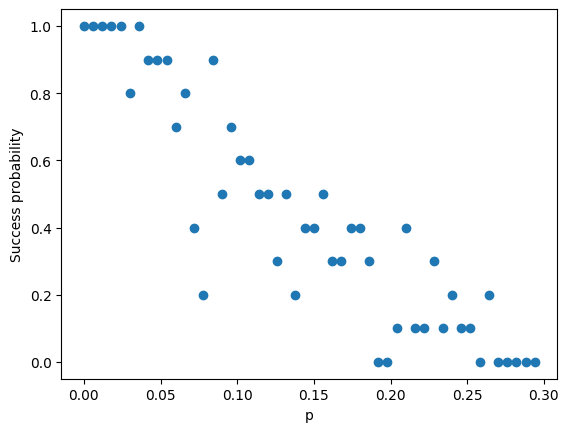

In [10]:
# data plotting

simulator = AerSimulator()

data_x = []
data_y = []

totalrounds = 50

# varies the value of p
for i in range(50):

    success = 0.0
    p = i/totalrounds*0.30
    
    # does 10 trials to calculate a value for the success probability given the value of p
    for j in range(10):
        rounds = 1
        compiled_circuit = transpile(CSS_correction_numpy(p), simulator)
        job = simulator.run(compiled_circuit, shots = rounds)
        counts = job.result().get_counts()
        for key in counts:
            if key[:15] in logical_zero_components:
                success += counts[key]

    success_probability = success/10
        
    data_x.append(p)
    data_y.append(success_probability)

plt.scatter(data_x, data_y)
plt.xlabel("p")
plt.ylabel("Success probability")
